In [1]:
# import necessary libraries for training model
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid

In [13]:
# load the data
data_dir = '../mimic_data_after_preprocess/training_set_smote25.csv'
train = pd.read_csv(data_dir)
test = pd.read_csv('../mimic_data_after_preprocess/testing_set25.csv')
simulation = pd.read_csv('../mimic_data_after_preprocess/simulation_set25.csv')

In [16]:
print(len(simulation), sum(simulation['adverse_flag']==1))
print("In simulation set, male ", sum(simulation['gender']==0), " female ", sum(simulation['gender']==1))
print("positive, male ", sum(simulation[simulation['gender']==0]['adverse_flag']==1))
print("positive, female ", sum(simulation[simulation['gender']==1]['adverse_flag']==1))

23098 531
In simulation set, male  12374  female  10724
positive, male  234
positive, female  297


In [3]:
# remove unnecessary columns
train = train.drop(['Unnamed: 0', 'age_1'], axis=1)
test = test.drop(['subject_id', 'age_1'], axis=1)
train_features = train.drop(['adverse_flag'], axis=1)
train_labels = train['adverse_flag']
test_features = test.drop(['adverse_flag'], axis=1)
test_labels = test['adverse_flag']

In [4]:
# split test set into validation set and test set
val_features, test_features, val_labels, test_labels = train_test_split(test_features,
                                                                        test_labels,
                                                                        test_size=0.5)

In [5]:
# print the shape of the data
print('train_features shape: ', train_features.shape)
print('train_labels shape: ', train_labels.shape)
print('val_features shape: ', val_features.shape)
print('val_labels shape: ', val_labels.shape)
print('test_features shape: ', test_features.shape)
print('test_labels shape: ', test_labels.shape)

train_features shape:  (90256, 24)
train_labels shape:  (90256,)
val_features shape:  (9239, 24)
val_labels shape:  (9239,)
test_features shape:  (9239, 24)
test_labels shape:  (9239,)


In [6]:
# create a pytorch multi-layer perceptron model
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for i in range(hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))

        self.activations = nn.ModuleList()
        for i in range(hidden_layers):
            self.activations.append(nn.ReLU())
        self.activations.append(nn.Sigmoid())

    def forward(self, x):
        out = x
        for i in range(self.hidden_layers + 1):
            out = self.layers[i](out)
            # if i != self.hidden_layers:
            out = self.activations[i](out)
        return out


In [7]:
# define a function to train and evaluate a given model on a given dataset
def train_and_eval(model, train_loader, test_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_loader:
                output = model(X)
                loss = criterion(output, y)
                test_loss += loss.item() * X.size(0)
                predicted = output > 0.5
                correct += (predicted == y).sum().item()
                total += y.size(0)
        test_loss /= len(test_loader.dataset)
        test_acc = correct / total

        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.2f}%'
              .format(epoch+1, epochs, train_loss, test_loss, test_acc*100))

    return test_acc


In [8]:
# completed code that loops over different hyperparameter settings
# define hyperparameters to search over
param_grid = {
    'hidden_layers': [5, 8, 10],
    'hidden_size': [64, 128, 256],
    'optimizer': [optim.Adam, optim.SGD],
    'lr': [0.001, 0.01, 0.1]
}

In [9]:
# check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
# turn pandas val_features, test_features, val_labels, test_labels into tensor
X_train = torch.tensor(train_features.values, dtype=torch.float32).to(device)
y_train = torch.tensor(train_labels.values.reshape(-1, 1), dtype=torch.float32).to(device)
X_test = torch.tensor(val_features.values, dtype=torch.float32).to(device)
y_test = torch.tensor(val_labels.values.reshape(-1, 1), dtype=torch.float32).to(device)
# create train and test datasets and loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
print(X_train.shape)

torch.Size([90256, 24])


In [12]:
# set up parameter grid search
best_acc = 0.0
best_params = None
for params in ParameterGrid(param_grid):
    print("Start", params)
    model = MLP(input_size=X_train.shape[1], output_size=1,
                hidden_layers=params['hidden_layers'],
                hidden_size=params['hidden_size'])
    model.to(device)
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'])
    criterion = nn.BCELoss()
    acc = train_and_eval(model, train_loader, test_loader, optimizer, criterion, epochs=16)
    if acc > best_acc:
        best_acc = acc
        best_params = params
    print("End:", acc)
    print("Current best:", best_acc)

print('Best Accuracy: {:.2f}%'.format(best_acc*100))
print('Best Parameters:', best_params)

Start {'hidden_layers': 5, 'hidden_size': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch [1/16], Train Loss: 0.3138, Test Loss: 0.2116, Test Acc: 92.67%
Epoch [2/16], Train Loss: 0.2755, Test Loss: 0.1774, Test Acc: 95.01%
Epoch [3/16], Train Loss: 0.2673, Test Loss: 0.1741, Test Acc: 94.37%
Epoch [4/16], Train Loss: 0.2618, Test Loss: 0.1923, Test Acc: 93.22%
Epoch [5/16], Train Loss: 0.2566, Test Loss: 0.1759, Test Acc: 93.39%
Epoch [6/16], Train Loss: 0.2515, Test Loss: 0.1760, Test Acc: 94.45%
Epoch [7/16], Train Loss: 0.2464, Test Loss: 0.1785, Test Acc: 94.14%
Epoch [8/16], Train Loss: 0.2421, Test Loss: 0.1879, Test Acc: 92.81%
Epoch [9/16], Train Loss: 0.2380, Test Loss: 0.1858, Test Acc: 93.32%
Epoch [10/16], Train Loss: 0.2340, Test Loss: 0.1929, Test Acc: 93.02%
Epoch [11/16], Train Loss: 0.2287, Test Loss: 0.1739, Test Acc: 93.77%
Epoch [12/16], Train Loss: 0.2258, Test Loss: 0.1757, Test Acc: 93.68%
Epoch [13/16], Train Loss: 0.2225, Test Loss: 0.1868

In [79]:
# do training
model = MLP(input_size=X_train.shape[1], output_size=1,
                hidden_layers=8,
                hidden_size=64)
model.to(device)
optimizer = optim.SGD(model.parameters(), 0.001)
criterion = nn.BCELoss()
acc = train_and_eval(model, train_loader, test_loader, optimizer, criterion, epochs=20)

Epoch [1/20], Train Loss: 0.5986, Test Loss: 0.4106, Test Acc: 97.63%
Epoch [2/20], Train Loss: 0.5172, Test Loss: 0.3145, Test Acc: 97.63%
Epoch [3/20], Train Loss: 0.4958, Test Loss: 0.2779, Test Acc: 97.62%
Epoch [4/20], Train Loss: 0.4776, Test Loss: 0.2691, Test Acc: 97.16%
Epoch [5/20], Train Loss: 0.4627, Test Loss: 0.2599, Test Acc: 96.54%
Epoch [6/20], Train Loss: 0.4560, Test Loss: 0.2464, Test Acc: 96.53%
Epoch [7/20], Train Loss: 0.4510, Test Loss: 0.2425, Test Acc: 96.41%
Epoch [8/20], Train Loss: 0.4444, Test Loss: 0.2415, Test Acc: 96.50%
Epoch [9/20], Train Loss: 0.4359, Test Loss: 0.2378, Test Acc: 96.54%
Epoch [10/20], Train Loss: 0.4247, Test Loss: 0.2290, Test Acc: 96.75%
Epoch [11/20], Train Loss: 0.4191, Test Loss: 0.2184, Test Acc: 97.01%
Epoch [12/20], Train Loss: 0.4133, Test Loss: 0.2330, Test Acc: 96.38%
Epoch [13/20], Train Loss: 0.4039, Test Loss: 0.2329, Test Acc: 96.50%
Epoch [14/20], Train Loss: 0.3928, Test Loss: 0.2550, Test Acc: 95.79%
Epoch [15/20], 

In [80]:
X_train.shape[1]

24

In [81]:
# calculate the fairness matrices on the testing dataset
with torch.no_grad():
    X = torch.tensor(test_features.values, dtype=torch.float32).to(device)
    Y = torch.tensor(test_labels.values.reshape(-1, 1), dtype=torch.float32).to(device)
    predicted_Y = model(X).cpu().numpy()

In [82]:
predicted_Y.shape

(9239, 1)

In [83]:
from sklearn.metrics import *
pred = predicted_Y>0.5
recall = recall_score(test_labels, pred)
precision = precision_score(test_labels, pred)
f1 = f1_score(test_labels, pred)
auc = roc_auc_score(test_labels, pred)
print('recall: ', recall)
print('precision: ', precision)
print('f1: ', f1)
print('auc: ', auc)

recall:  0.4669603524229075
precision:  0.2872628726287263
f1:  0.3557046979865772
auc:  0.7188885206411031


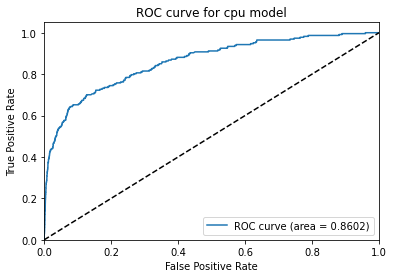

In [84]:
# plot the roc curve
import matplotlib.pyplot as plt
probas_ = predicted_Y.copy()
fpr, tpr, thresholds = roc_curve(test_labels, probas_)
auc = roc_auc_score(test_labels, probas_)
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for cpu model')
plt.legend(loc="lower right")
plt.show()

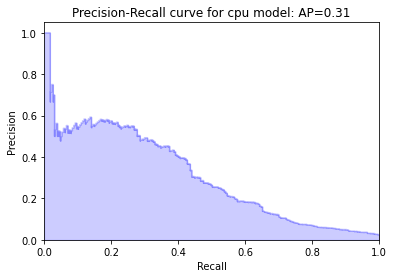

In [85]:
# plot the precision recall curve
precision, recall, _ = precision_recall_curve(test_labels, probas_)
average_precision = average_precision_score(test_labels, probas_)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for cpu model: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [86]:
# find the optimal threshold on roc curve
probas_ = predicted_Y.copy()
fpr, tpr, thresholds = roc_curve(test_labels, probas_)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
thresholdOpt = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdOpt, gmeans[ix]))
print('tpr: ', tpr[ix], 'fpr: ', fpr[ix])
print('precision: ', precision_score(test_labels, probas_ >= thresholdOpt))
print('recall: ', recall_score(test_labels, probas_ >= thresholdOpt))
print('f1_score: ', f1_score(test_labels, probas_ >= thresholdOpt))

# find the threshold that maximize the f1 score
thresholds_f1 = np.arange(0, 1, 0.01)
f1_scores = []
fpr_f1 = []
tpr_f1 = []
accuracy_f1 = []
precision_f1 = []
for threshold in thresholds_f1:
    preds_f1 = probas_ >= threshold
    f1_scores.append(f1_score(test_labels, preds_f1))
    tn, fp, fn, tp = confusion_matrix(test_labels, preds_f1).ravel()
    fpr_f1.append(fp / (fp + tn))
    tpr_f1.append(tp / (tp + fn))
    accuracy_f1.append((tp + tn) / (tp + tn + fp + fn))
    precision_f1.append(tp / (tp + fp))
thresholdOpt_f1 = thresholds_f1[np.argmax(f1_scores)]
print('thresholdOpt: ', thresholdOpt_f1)
print('tpr: ', tpr_f1[np.argmax(f1_scores)], 'fpr: ', fpr_f1[np.argmax(f1_scores)])
print('precision: ', precision_f1[np.argmax(f1_scores)])
print('recall: ', recall_score(test_labels, probas_ >= thresholdOpt_f1))
print('f1_score: ', np.max(f1_scores))
print('accuracy: ', accuracy_f1[np.argmax(f1_scores)])
# precision = tp / (tp + fp)

Best Threshold=0.222405, G-Mean=0.782
tpr:  0.7004405286343612 fpr:  0.12660896582334666
precision:  0.12230769230769231
recall:  0.7004405286343612
f1_score:  0.20825147347740666
thresholdOpt:  0.61
tpr:  0.3876651982378855 fpr:  0.012982689747003996
precision:  0.4292682926829268
recall:  0.3876651982378855
f1_score:  0.4074074074074074
accuracy:  0.9722913735252733


In [87]:
# save the MLP model
import pickle
save_dir = "./models/model_mlp.pth"
torch.save(model.state_dict(), save_dir)
with open('./models/precision_mlp.pkl', 'wb') as f:
    pickle.dump(precision_f1, f)